In [1]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import pandas as pd

import LE as le
import LP as lp
import iterative as iterative
import graph_viz as viz
import logger_creator

from graph_gen import create_delegation_graph
import graph_tools
import networkx as nx

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [ ]:
range_x = range(0, 1000, 200)

time_data_le = []
time_data_lp = []
time_data_iterative = []

logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        countdown = 5
        while countdown > 0:
            countdown -= 1

            complete_graph = nx.gnp_random_graph(num_nodes, p=0.60, directed=True)#complete_graph(num_nodes)
            complete_graph = nx.relabel_nodes(complete_graph, {node: str(node) for node in complete_graph.nodes()})
            delegation_graph = graph_tools.prepare_graph(complete_graph.nodes(), complete_graph.edges(), sink_frac = 0.01)
            delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
            delegations = graph_tools.invert_graph(delegations_orig)
            nodes = list(delegation_graph)

            try: 
                lp_model = lp.set_up(delegations, nodes)
                _ = lp.resolve_delegations(delegations, nodes)
                break
            except:
                print(lp_model)
                SEED += 1
                print("Graph infeasible, retrying")

        # Verify the solutions are equal
        powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes, cutoff=0.0001)

        if powers_le != powers_lp:
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 10
        if 0 <= num_nodes < 500:
            n = 20
        elif 500 <= num_nodes < 1000:
            n = 10

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes, cutoff=0.0001)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE")
    plt.plot(x, time_data_lp[i], label=f"LP") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()

0
200
Mismatching powers in LP and Iterative. Check the log file for details.
400
Mismatching powers in LP and Iterative. Check the log file for details.


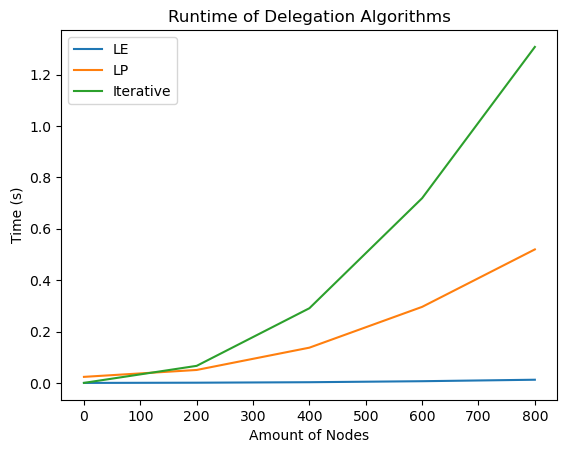

In [13]:
for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE")
    plt.plot(x, time_data_lp[i], label=f"LP") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()

In [30]:
num_nodes = 5

complete_graph = nx.gnp_random_graph(num_nodes, p=0.60, directed=True)
complete_graph = nx.relabel_nodes(complete_graph, {node: str(node) for node in complete_graph.nodes()})
delegation_graph = graph_tools.prepare_graph(complete_graph.nodes(), complete_graph.edges(), sink_frac = 0.1)
delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
delegations = graph_tools.invert_graph(delegations_orig)
nodes = list(delegation_graph)

powers = iterative.iterate_delegations(delegations, nodes)

In [31]:
display(powers)
viz.visualize_delegation_graph(delegations_orig, powers)

{'0': 0.0012189075092731783,
 '1': 0.0018355395494705266,
 '3': 0.0008946715927809157,
 '4': 0.0009651588131714639,
 '2': 4.995085722535308}

Parsing the data...Done
Parsing the data...Done
Parsing the data...Done


Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.
Address already in use
Port 8051 is in use by another program. Either identify and stop that program, or start the server with a different port.


Graph visualization failed because no ports were found or there was another error.


No trigger
